<a href="https://colab.research.google.com/github/khushbooG9/Pointer-Networks-Using-Fast-Weights/blob/master/Pointer_Networks_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

tf.enable_eager_execution()

In [0]:
np.random.seed(42)
tf.random.set_random_seed(42)

### Prepare dataset

In [3]:
datasize=32*200

minSeqSize=3
maxSeqSize=3
np.random.seed(42)
tf.random.set_random_seed(42)

dataX=[]

for aRec in range(datasize):
    seqLen=np.random.randint(minSeqSize,maxSeqSize+1)
    aSeq=np.concatenate((np.zeros((1,seqLen),dtype=np.float32),np.random.uniform(size=(1,seqLen)),np.zeros((1,seqLen),dtype=np.float32)),axis=0).T
    aSeq1=np.concatenate((np.array([[1,0,0]],dtype=np.float32),aSeq),axis=0)
    dataX+=[aSeq1]
    
dataX=np.array(dataX,dtype=np.float32)
encoder_input_data=dataX
encoder_input_data.shape

(6400, 4, 3)

In [4]:
input_encoder=encoder_input_data[0]
input_encoder

array([[1.        , 0.        , 0.        ],
       [0.        , 0.37454012, 0.        ],
       [0.        , 0.9507143 , 0.        ],
       [0.        , 0.7319939 , 0.        ]], dtype=float32)

In [5]:
encoder_input_data[:5]

array([[[1.        , 0.        , 0.        ],
        [0.        , 0.37454012, 0.        ],
        [0.        , 0.9507143 , 0.        ],
        [0.        , 0.7319939 , 0.        ]],

       [[1.        , 0.        , 0.        ],
        [0.        , 0.5986585 , 0.        ],
        [0.        , 0.15601864, 0.        ],
        [0.        , 0.15599452, 0.        ]],

       [[1.        , 0.        , 0.        ],
        [0.        , 0.05808361, 0.        ],
        [0.        , 0.8661761 , 0.        ],
        [0.        , 0.601115  , 0.        ]],

       [[1.        , 0.        , 0.        ],
        [0.        , 0.7080726 , 0.        ],
        [0.        , 0.02058449, 0.        ],
        [0.        , 0.96990985, 0.        ]],

       [[1.        , 0.        , 0.        ],
        [0.        , 0.83244264, 0.        ],
        [0.        , 0.21233912, 0.        ],
        [0.        , 0.18182497, 0.        ]]], dtype=float32)

In [6]:
target_data=[]
for i in range(dataX.shape[0]):
    arr=dataX[i]
    x=arr[:,1][1:]
    aRec=[([0]*(seqLen+1))+[1]]
    aRec=[]
    for e in np.sort(x):
        idx=list(x).index(e)
        aRec+=[np.zeros(seqLen+1,dtype=np.float32)]
        aRec[-1][idx+1]=1
    aRec+=[np.array([1,0,0,0],dtype=np.float32)]
    target_data+=[aRec]
target_data=np.array(target_data)
print(target_data.shape)
target_data[0:2]

(6400, 4, 4)


array([[[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]],

       [[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]]], dtype=float32)

In [7]:
output_pred=target_data[0]
output_pred

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [8]:
decoder_dummy_input=np.array([[0,0,1]],dtype=np.float32)
decoder_dummy_input=tf.convert_to_tensor(decoder_dummy_input)
decoder_dummy_input

<tf.Tensor: id=0, shape=(1, 3), dtype=float32, numpy=array([[0., 0., 1.]], dtype=float32)>

## Encoder & Decoder Network

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden_dimensions):
        super(Encoder, self).__init__()
        self.lstm = layers.LSTM(hidden_dimensions, return_sequences=True, return_state=True)
        
    def call(self, x):
        output, state_h, state_c  = self.lstm(x)        
        return output, [state_h, state_c]

In [0]:
class Decoder(tf.keras.Model):
     def __init__(self, hidden_dimensions):
        super(Decoder, self).__init__()
        self.lstm = layers.LSTM(hidden_dimensions, return_sequences=True, return_state=True)
     
     def call(self, x, hidden_states):
        dec_output, state_h, state_c  = self.lstm(x, initial_state=hidden_states)
        # dec_output shape -> (batch_size, 1, hidden_dimension)

        return dec_output, [state_h, state_c]

In [0]:
class Attention(tf.keras.Model):
     def __init__(self, hidden_dimensions):
        super(Attention, self).__init__()
        # Note: Dense layer -> dot(input, kernel) -> so now Ui = vT . tanh(W1 . e + W2 . di)  becomes Ui = tanh(e . W1 + di . W2) . v
        self.W1 = tf.keras.layers.Dense(hidden_dimensions, use_bias=False) # weights -> (256, 256)
        self.W2 = tf.keras.layers.Dense(hidden_dimensions, use_bias=False) # weights -> (256, 256)
        self.V = tf.keras.layers.Dense(1, use_bias=False) # weights -> (256, 1)
        
     
     def call(self, encoder_outputs, dec_output):
        # encoder_outputs shape -> (batch_size, input_sequence_length, hidden_dimension) -> (32, 9, 256)
        # dec_output shape -> (batch_size, 1, hidden_dimension) -> (32, 1, 256)

        # w1_e -> (*, 9, 256) * (*, 256, 256) -> (*, 9, 256)
        w1_e = self.W1(encoder_outputs)
        
        # w2_e -> (*, 1, 256) * (*, 256, 256) -> (*, 1, 256)
        w2_d = self.W2(dec_output)
        
        # tanh_output -> (*, 9, 256) + (*, 1, 256) -> (*, 9, 256)
        tanh_output = tf.nn.tanh(w1_e + w2_d)
        
        # tanh_output -> (*, 9, 256) + (*, 256, 1) -> (*, 9, 1)
        v_dot_tanh = self.V(tanh_output)
        
        # attention_weights -> (batch_size, input_sequence_length, 1) -> (32, 9, 1)
        attention_weights = tf.nn.softmax(v_dot_tanh, axis=1)
        
        return tf.reshape(attention_weights, (attention_weights.shape[0], attention_weights.shape[1])) # (batch_size, input_sequence_length) -> (32, 9)

In [0]:
hidden_dimensions=30

### Initialize encoder and decoder network

In [0]:
encoder = Encoder(hidden_dimensions)
decoder = Decoder(hidden_dimensions)
attention = Attention(hidden_dimensions)

### Setup tensorflow dataset for traning 

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data,target_data))
batches = 32
dataset = dataset.shuffle(100).batch(32)

#### Output of network before training

In [0]:
#Initialize values
attention_vector_array = []
final_output_sequence = []

# expand the sequences to be batch size of 1 to be fed as input
encoder_input = tf.expand_dims(input_encoder, 0)
target_data = tf.expand_dims(output_pred, 0)

In [16]:
encoder_input

<tf.Tensor: id=20, shape=(1, 4, 3), dtype=float32, numpy=
array([[[1.        , 0.        , 0.        ],
        [0.        , 0.37454012, 0.        ],
        [0.        , 0.9507143 , 0.        ],
        [0.        , 0.7319939 , 0.        ]]], dtype=float32)>

In [17]:
target_data

<tf.Tensor: id=23, shape=(1, 4, 4), dtype=float32, numpy=
array([[[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]]], dtype=float32)>

In [18]:
# encoder_input shapes -> (batch_size, input_sequence_length, input_dimension)
# encoder_outputs shape -> (batch_size, input_sequence_length, hidden_dimension)
encoder_outputs, encoder_states = encoder(encoder_input)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
encoder_outputs

<tf.Tensor: id=704, shape=(1, 4, 30), dtype=float32, numpy=
array([[[-5.01736924e-02,  3.16948779e-02,  4.12515774e-02,
         -3.53498310e-02,  4.03320044e-02,  5.54589704e-02,
          2.25627013e-02,  7.67772552e-03,  1.25065474e-02,
          4.34280075e-02, -3.51917446e-02, -4.26367745e-02,
          1.18723800e-02,  1.20848594e-02,  1.52343558e-02,
          2.52943626e-03,  3.65303047e-02, -2.87996512e-02,
         -3.56858447e-02, -3.98900062e-02, -3.35637480e-02,
          3.72589752e-02,  4.25086394e-02,  5.63450158e-04,
          4.19360884e-02,  2.39714514e-02,  3.57869896e-03,
         -1.72660686e-02,  1.52625805e-02,  3.94967645e-02],
        [-2.22421326e-02,  2.47765277e-02,  3.65987234e-02,
         -4.23405543e-02,  1.13524478e-02,  3.23084295e-02,
          1.95754655e-02, -9.81311128e-03, -7.96766859e-03,
          3.69066931e-02, -4.04213220e-02, -3.13852206e-02,
          2.37852950e-02,  3.13127926e-03, -5.76501770e-05,
          9.14086215e-03,  4.37631737e-

In [20]:
encoder_states

[<tf.Tensor: id=690, shape=(1, 30), dtype=float32, numpy=
 array([[ 0.02443983,  0.03203559,  0.02158026, -0.09165885, -0.07113244,
          0.00900422,  0.01566898, -0.05971602, -0.04910487,  0.04008957,
         -0.0752905 , -0.01764187,  0.06615766, -0.01010191, -0.01688974,
          0.03577784, -0.05767062, -0.04832567, -0.07000051, -0.09081741,
          0.04363935,  0.09219287,  0.07154807,  0.02030761, -0.01588933,
          0.02627038,  0.0458793 , -0.05890446,  0.00721262,  0.08865698]],
       dtype=float32)>,
 <tf.Tensor: id=673, shape=(1, 30), dtype=float32, numpy=
 array([[ 0.05119281,  0.06086827,  0.04373739, -0.19406971, -0.14232066,
          0.01806413,  0.03184876, -0.12546046, -0.09462173,  0.07565732,
         -0.15041617, -0.03344038,  0.12792736, -0.01976309, -0.03190866,
          0.06723674, -0.1205032 , -0.09313053, -0.13895768, -0.18442363,
          0.08514079,  0.18679911,  0.14010568,  0.04275992, -0.03289884,
          0.05114478,  0.09684512, -0.122790

In [21]:
# first decoder input '=>'
dec_input = tf.expand_dims(decoder_dummy_input, 1)
dec_input

<tf.Tensor: id=709, shape=(1, 1, 3), dtype=float32, numpy=array([[[0., 0., 1.]]], dtype=float32)>

In [0]:
# loading the final encoder states to decoder network as initial hidden states
decoder_states = encoder_states

In [23]:
print("\nPrediction for ")
for i in range(0, encoder_input.shape[1]):
    decoder_output, decoder_states = decoder(dec_input, decoder_states)
    target_prediction = attention(encoder_outputs, decoder_output)
    
    # Save the attention vector
    attention_vector_array.append(target_prediction.numpy()[0])
    final_output_sequence.append(np.round(target_prediction.numpy()[0])) # why use np.round here ?? why not np.argmax ??
    print("%dth position -> %d -> %s"%(i, np.argmax(target_prediction), str(encoder_input[:,np.argmax(target_prediction)])))
    
    # pass the predicted value as next input state to decoder network
    dec_input = tf.expand_dims(encoder_input[:, np.argmax(target_prediction)], 1) # works only for one input combination

print("\nTarget output values (softmax values over the input sequence size)")
print(target_data.numpy()[0])
print("\nPredicted output values")
print(np.array(final_output_sequence))


Prediction for 
0th position -> 0 -> tf.Tensor([[1. 0. 0.]], shape=(1, 3), dtype=float32)
1th position -> 0 -> tf.Tensor([[1. 0. 0.]], shape=(1, 3), dtype=float32)
2th position -> 0 -> tf.Tensor([[1. 0. 0.]], shape=(1, 3), dtype=float32)
3th position -> 0 -> tf.Tensor([[1. 0. 0.]], shape=(1, 3), dtype=float32)

Target output values (softmax values over the input sequence size)
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]

Predicted output values
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Train Model

In [0]:
optimizer = tf.train.AdamOptimizer()

In [25]:
epochs = 4 # was over fitting beyond this
loss_history = []
total_attention = []
for epoch in range(epochs):
    # encoder_input shapes -> (batch_size, input_sequence_length, input_dimension)
    print("NEW EPOCH:",epoch)
    for (batch, (encoder_input, target_data)) in enumerate(dataset):
        loss = 0
        with tf.GradientTape() as tape:
            encoder_outputs, encoder_states = encoder(encoder_input)
            # encoder_outputs shape -> (batch_size, input_sequence_length, hidden_state_dimension) -> (32, 9, 256)
            # encoder states shape -> (batch_size, hidden_state_dimension) -> (32, 256)
    
            # first decoder input '=>'
            # dec_input shape -> (batch_size, input_lenght=1, input_dimension) -> (32, 1, 64)
            # dec_input = tf.expand_dims(encoder_input[:, 0], 1) # The '=>' symbol loaded as input
            dec_input = tf.tile(tf.expand_dims(decoder_dummy_input, 1),tf.convert_to_tensor(np.array([batches,1,1])))
            
            # loading the final encoder states to decoder network as initial hidden states
            # decoder states shape -> (batch_size, hidden_state_dimension) -> (32, 256)
            decoder_states = encoder_states

            # track attention over each output sequence
            attention_vector_array = []
            
            # iterrate over the times of input sequence size or till the output points to '=>' symbol
            for i in range(0, encoder_input.shape[1]):
                # decoder outputs shape -> (batch_size, input_lenght=1, hidden_state_dimension) -> (32, 1, 256)
                # decoder states shape -> (batch_size, hidden_state_dimension) -> (32, 256)
                decoder_output, decoder_states = decoder(dec_input, decoder_states)

                # target prediction -> (batch_size, input_sequence_length) -> (32, 9)
                # target prediction points to one of the input sequence element -> element with highest value
                target_prediction = attention(encoder_outputs, decoder_output)

                if batch % 10 == 0:
                    attention_vector_array.append(target_prediction.numpy()[0])

                # used for training the network by using the target data
                tar_data = target_data[:, i]
                
                tarCounter=0
                ei_slice_stack=[]
                for tar_data_slice in tar_data:
                    ei_slice_stack+=[encoder_input[tarCounter,np.argmax(tar_data_slice)]]
                ei_slice_stack=tf.convert_to_tensor(np.array(ei_slice_stack,dtype=np.float32))
                    
                    
                
                # load the input state to decoder network for next prediction
                dec_input = tf.expand_dims(ei_slice_stack, 1) # Works only for one input combination

                # loss value calculated as categorical crossentropy
                loss += tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))
        batch_loss = (loss / batches)
        if batch % 10 == 0:
            total_attention.append(attention_vector_array)
            print("\tEpoch {:03d}/{:03d}: Loss at step {:02d}: {:.9f}".format((epoch+1), epochs, batch, tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))))
        # store the loss history 
        loss_history.append(batch_loss.numpy())
        # fetch the trainable variables
        variables = encoder.variables + decoder.variables
        # calculate the gradient
        grads = tape.gradient(loss, variables)
        # update the weights of the network
        optimizer.apply_gradients(zip(grads, variables), global_step=tf.train.get_or_create_global_step())
    print("Epoch {:03d}/{:03d} completed \t - \tBatch loss: {:.9f}".format((epoch+1), epochs, tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))))
print("Final loss: {:.9f}".format(tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))))

NEW EPOCH: 0
	Epoch 001/004: Loss at step 00: 1.365067959
	Epoch 001/004: Loss at step 10: 1.394328713
	Epoch 001/004: Loss at step 20: 1.381916761
	Epoch 001/004: Loss at step 30: 1.390063286
	Epoch 001/004: Loss at step 40: 1.389225364
	Epoch 001/004: Loss at step 50: 1.374649882
	Epoch 001/004: Loss at step 60: 1.364059448
	Epoch 001/004: Loss at step 70: 1.316788793
	Epoch 001/004: Loss at step 80: 1.266419768
	Epoch 001/004: Loss at step 90: 1.196208954
	Epoch 001/004: Loss at step 100: 1.060602069
	Epoch 001/004: Loss at step 110: 0.957106352
	Epoch 001/004: Loss at step 120: 0.847798467
	Epoch 001/004: Loss at step 130: 0.774947643
	Epoch 001/004: Loss at step 140: 0.697331131
	Epoch 001/004: Loss at step 150: 0.653275430
	Epoch 001/004: Loss at step 160: 0.617102385
	Epoch 001/004: Loss at step 170: 0.551599145
	Epoch 001/004: Loss at step 180: 0.507576168
	Epoch 001/004: Loss at step 190: 0.494732380
Epoch 001/004 completed 	 - 	Batch loss: 0.490682870
NEW EPOCH: 1
	Epoch 002/

#### Attention plot over the input sequence

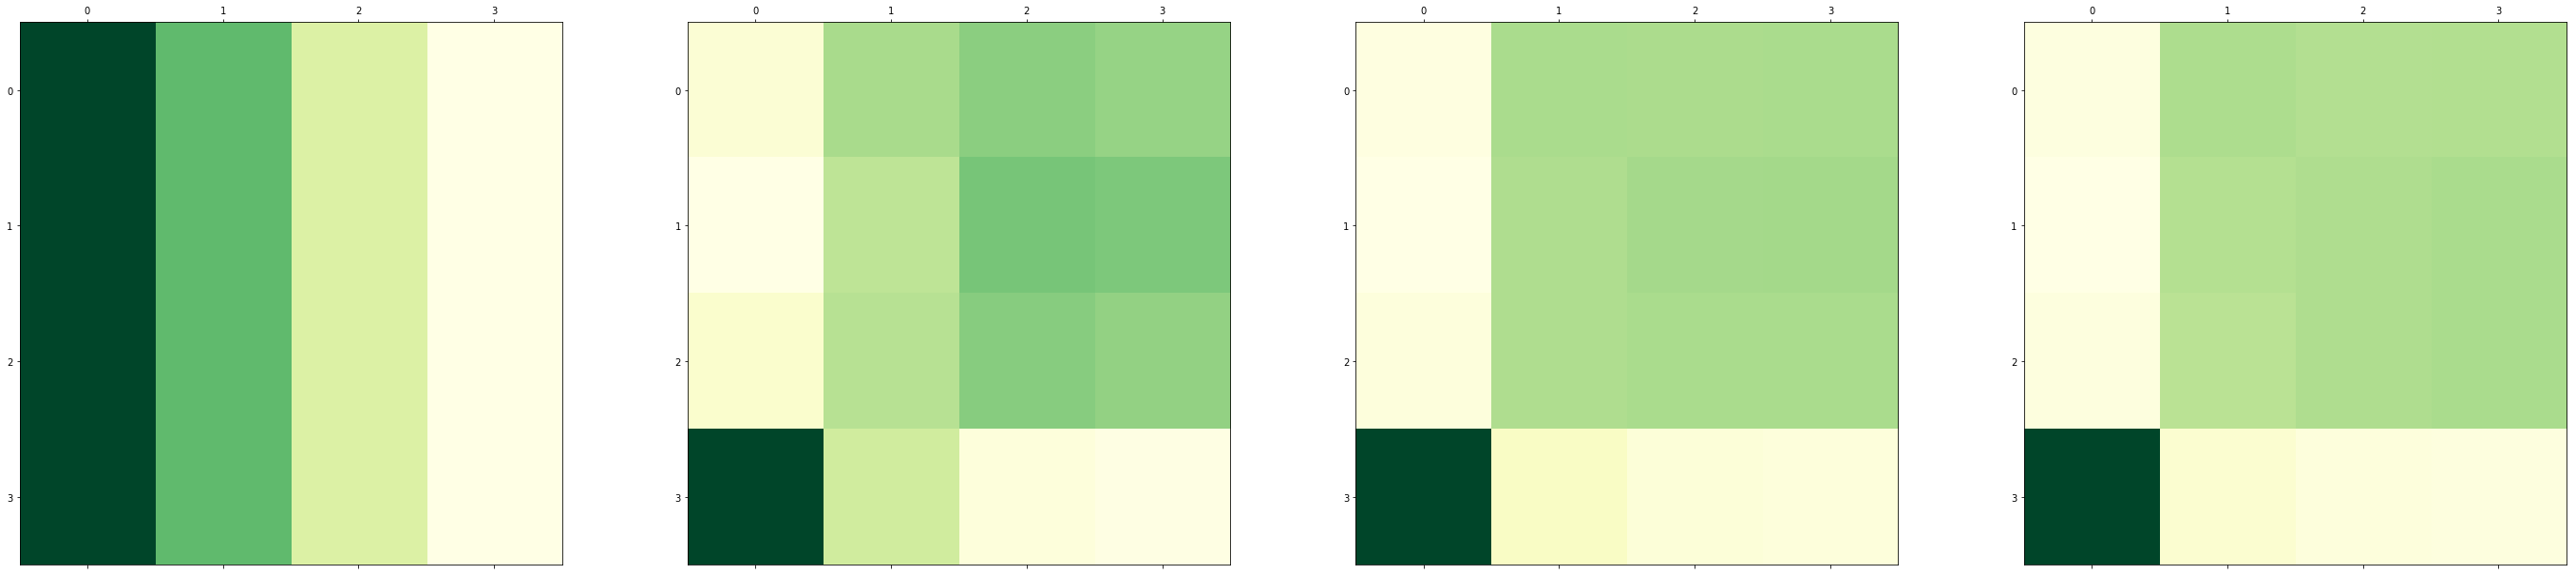

In [26]:
figstep=20
fig = plt.figure(figsize=(250,250))
for i in range(1, len(total_attention),figstep):
    fig.add_subplot(len(total_attention)/4, len(total_attention)/4, int(i/figstep)+1).matshow(np.array(total_attention[i-1]), cmap='YlGn')
plt.show()

### Loss plot over the entire training sequence

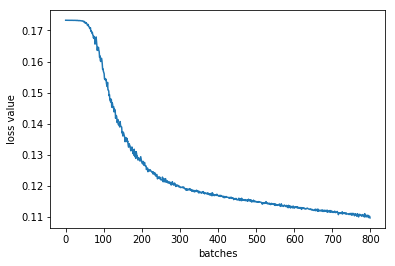

In [27]:
plt.plot(loss_history)

plt.ylabel('loss value')
plt.xlabel('batches')

plt.show()

### Inference Model

#### Output of network before training

In [28]:
input_encoder[1,1]=0.1
input_encoder[2,1]=0.9
input_encoder[3,1]=0.5
print(input_encoder)
target_data1=[]
arr=input_encoder
x=arr[:,1][1:]
aRec=[([0]*(seqLen+1))+[1]]
aRec=[]
for e in np.sort(x):
    idx=list(x).index(e)
    aRec+=[np.zeros(seqLen+1,dtype=np.float32)]
    aRec[-1][idx+1]=1
aRec+=[np.array([1,0,0,0],dtype=np.float32)]
target_data1+=[aRec]
target_data1=np.array(target_data1)
print(target_data1.shape)
output_pred=target_data1
output_pred

[[1.  0.  0. ]
 [0.  0.1 0. ]
 [0.  0.9 0. ]
 [0.  0.5 0. ]]
(1, 4, 4)


array([[[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]]], dtype=float32)

In [29]:
#Initialize values
attention_vector_array = []
final_output_sequence = []

# expand the sequences to be batch size of 1 to be fed as input
encoder_input = tf.expand_dims(input_encoder, 0)
target_data = tf.expand_dims(output_pred, 0)

# encoder_input shapes -> (number_of_inputs, input_sequence_length, input_dimension)
# encoder_outputs shape -> (number_of_inputs, input_sequence_length, hidden_dimension)
encoder_outputs, encoder_states = encoder(encoder_input)

# first decoder input '=>'
dec_input = tf.expand_dims(encoder_input[:, 0], 1)

# loading the final encoder states to decoder network as initial hidden states
decoder_states = encoder_states

print("\nPrediction for ")
for i in range(0, encoder_input.shape[1]):
#     print()
    decoder_output, decoder_states = decoder(dec_input, decoder_states)
    target_prediction = attention(encoder_outputs, decoder_output)
#     print(target_prediction)
    # Save the attention vector
    attention_vector_array.append(target_prediction.numpy()[0])
    o=np.argmax(target_prediction.numpy()[0])
    x=np.zeros((4))
    x[o]=1
    final_output_sequence.append(x)
    print("%dth position -> %d -> %s"%(i, np.argmax(target_prediction), str(encoder_input[:,np.argmax(target_prediction)])))

    # pass the predicted value as next input state to decoder network
    dec_input = tf.expand_dims(encoder_input[:, np.argmax(target_prediction)], 1) # works only for one input combination

print("\nTarget output values (softmax values over the input sequence size)")
print(target_data.numpy()[0])
print("\nPredicted output values")
print(np.array(final_output_sequence))


Prediction for 
0th position -> 1 -> tf.Tensor([[0.  0.1 0. ]], shape=(1, 3), dtype=float32)
1th position -> 2 -> tf.Tensor([[0.  0.9 0. ]], shape=(1, 3), dtype=float32)
2th position -> 2 -> tf.Tensor([[0.  0.9 0. ]], shape=(1, 3), dtype=float32)
3th position -> 0 -> tf.Tensor([[1. 0. 0.]], shape=(1, 3), dtype=float32)

Target output values (softmax values over the input sequence size)
[[[0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]]]

Predicted output values
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


In [30]:
target_prediction.numpy().T

array([[0.81595695],
       [0.07664619],
       [0.05912579],
       [0.04827117]], dtype=float32)

In [31]:
np.array(attention_vector_array)

array([[0.05136254, 0.33156893, 0.3013986 , 0.31566995],
       [0.03330924, 0.31449947, 0.33630517, 0.31588605],
       [0.04223281, 0.28690168, 0.37474245, 0.29612306],
       [0.81595695, 0.07664619, 0.05912579, 0.04827117]], dtype=float32)

References:

* https://arxiv.org/pdf/1506.03134.pdf
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense